In [45]:
# ideas
# vlt auch nochmal die dublicates im allgemeinen raushauen oder startifien 
# check wie viele duplicates im oder außerhalb vom split sind
# mass als baseline benutzen, dann nehme ich alle und mache feature im portance gehe nur mit mass und charge weiter dann mache ich randomized cross validation und zeige wie sich die features angepasst haben
# min max nach dem splitten 



# load and show dataset
import pandas as pd

file_path = 'RandomForest Datenset 1.csv'
data = pd.read_csv(file_path, sep = "\t").dropna()
print(data['Charge'].value_counts())

data

Charge
2    78454
1    35452
3    26913
4     3294
Name: count, dtype: int64


,Sequence,Charge,Mass,Length,CCS,NumRotatableBonds,NumConformers,NumAtoms,FractionSP3
0,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,4,4401.106890,52,2.654046e-35,134.0,0.0,309.0,0.668508
1,AAAAAAAAAK,1,785.439552,10,5.981752e-36,23.0,0.0,55.0,0.696970
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,2367.203020,29,1.208337e-35,64.0,0.0,166.0,0.696970
3,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,2367.203020,29,2.200959e-35,64.0,0.0,166.0,0.696970
4,AAAAAAAK,1,643.365324,8,6.811654e-36,19.0,0.0,45.0,0.703704
...,...,...,...,...,...,...,...,...,...
144112,YYYNCRTEVSQWEK,3,1924.841400,14,2.846427e-35,58.0,0.0,132.0,0.464286
144113,YYYNCRTEVSQWEKPK,3,2149.989120,16,2.854486e-35,65.0,0.0,148.0,0.505263
144114,YYYQGCASWK,2,1324.554660,10,1.742139e-35,36.0,0.0,90.0,0.383333
144115,YYYVCQYCPAMKTYLNK,3,2264.010450,17,2.726609e-35,64.0,0.0,150.0,0.510000


In [46]:
# Schritt 1: Nach Sequenzen gruppieren
grouped = data.groupby("Sequence")

# Erstellen einer Liste, in der jede Sequenz eine Gruppe ist
grouped_data = [(seq, group) for seq, group in grouped]

In [47]:

# splitting
from sklearn.model_selection import train_test_split

X_unscaled = data.drop(columns=['CCS', 'Sequence', 'NumConformers'])
y_unscaled = data['CCS']

train_groups, test_groups = train_test_split(grouped_data, test_size = 0.2, random_state=42)

# Schritt 3: Die Gruppendaten wieder in DataFrames konvertieren
train_df = pd.concat([group for _, group in train_groups])
test_df = pd.concat([group for _, group in test_groups])

In [48]:
len(train_df)

115284

In [49]:
len(test_df)

28829

In [50]:
# Schritt 4: Sicherstellen, dass keine Sequenz in beiden Splits vorkommt
# Liste der Sequenzen in test_df
test_sequences = test_df['Sequence'].unique()

# Entfernen aller Zeilen aus train_df, deren Sequenz auch in test_df vorkommt
train_df = train_df[~train_df['Sequence'].isin(test_sequences)]

train_df



115284

In [83]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
X_scaler = MinMaxScaler()

# scale train
y_train_unscaled = train_df['CCS'].values.reshape(-1,1) * 1e40
y_train = y_scaler.fit_transform(y_train_unscaled)
X_train_unscaled = train_df.drop(columns=['CCS', 'Sequence', 'NumConformers'])
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_unscaled), columns=X_train_unscaled.columns)

In [86]:

# scale test 
y_test_unscaled = test_df['CCS'].values.reshape(-1,1) * 1e40
y_test = y_scaler.transform(y_test_unscaled)
X_test_unscaled = test_df.drop(columns=['CCS', 'Sequence', 'NumConformers'])
X_test = pd.DataFrame(X_scaler.transform(X_test_unscaled), columns=X_test_unscaled.columns)

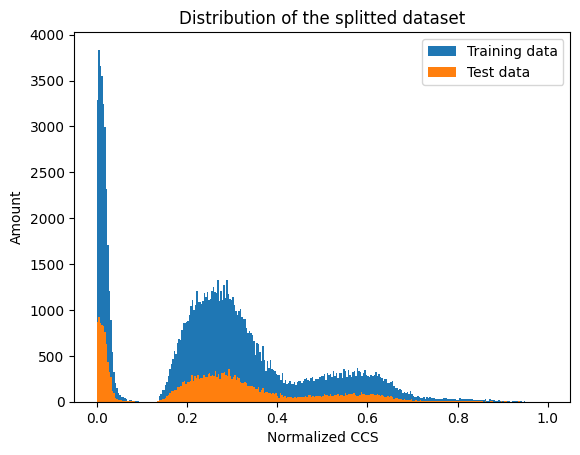

In [87]:

import matplotlib.pyplot as plt
plt.hist(y_train, label="Training data", bins=300)
plt.hist(y_test, label= "Test data", bins=300)
plt.title("Distribution of the splitted dataset")
plt.ylabel("Amount")
plt.xlabel("Normalized CCS")
plt.legend()
plt.show()

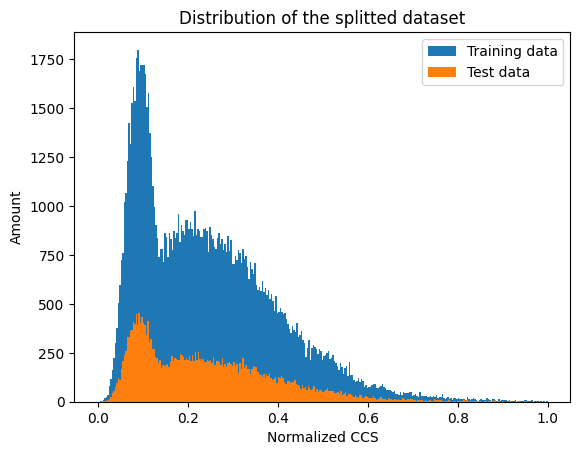

In [88]:

plt.hist(X_train["Mass"], label="Training data", bins=300)
plt.hist(X_test["Mass"], label= "Test data", bins=300)
plt.title("Distribution of the splitted dataset")
plt.ylabel("Amount")
plt.xlabel("Normalized CCS")
plt.legend()
plt.show()


In [94]:
X_train.columns

Index(['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms',
       'FractionSP3'],
      dtype='object')

In [107]:
# train first model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

cur_features = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']


model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train[cur_features], y_train.ravel())

# output results from cross-validation
# scores = cross_val_score(model, X, y.ravel(), cv=5, scoring='r2')
# print("Cross-validation scores for each fold:", scores)
# print("Mean cross-validation score:", scores.mean())

# evaluate first model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = model.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.00040582496803395166
Mean Absolute Error: 0.011666453054849573
R² Score: 0.9893734536962259


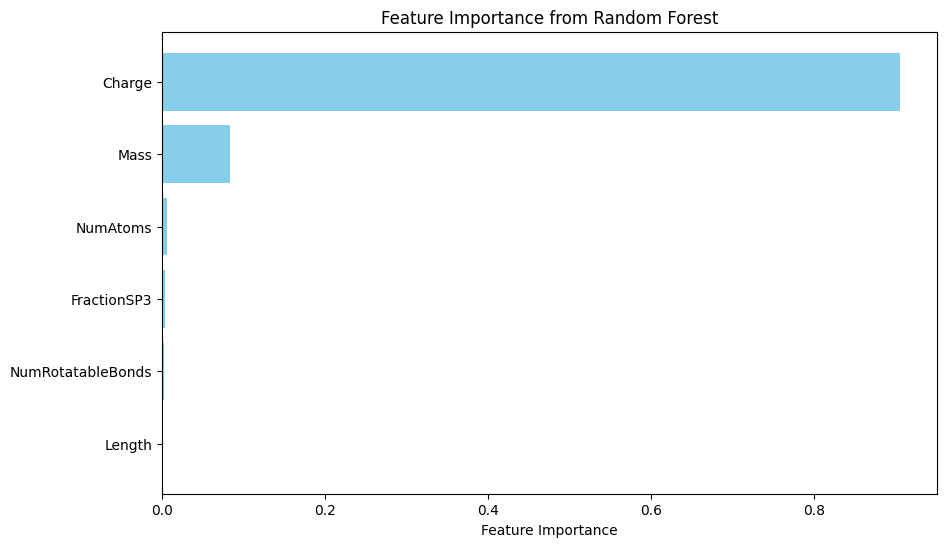

,feature,importance
0,Charge,0.905669
1,Mass,0.082958
4,NumAtoms,0.005987
5,FractionSP3,0.002822
3,NumRotatableBonds,0.001603
2,Length,0.000961


In [109]:
# Extract feature importances
importances = model.feature_importances_
feature_names = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

# Sort the features by importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Reverse order to have the most important at the top
plt.show()

feature_importances

In [ ]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': list(range(1,25)),
    'max_depth': list(range(1,30)),
    'min_samples_split': list(range(1,10)),
    'max_features': list(range(1,10)),
    'min_samples_leaf': list(range(1,15))
}


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X, y.ravel())

print("Beste Parameter:", random_search.best_params_)


In [ ]:
# evaluate optimized model

# Output results from cross-validation
best_model = random_search.best_estimator_
scores = cross_val_score(best_model, X, y.ravel(), cv=5, scoring='r2')
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", scores.mean())

# Output results from testing
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

In [ ]:
from plotnine import ggplot, aes, geom_point, labs, scale_color_brewer, scale_color_distiller, scale_fill_gradient

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")

    + geom_point() 
    
    # + scale_color_distiller(palette = "Blues")

)


In [ ]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(
   estimator=best_model, X=X_train, y=y_train.ravel(), train_sizes=[10,100,1000,10000,50000], cv=5, scoring='r2', verbose=2, random_state=42)

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay

#'neg_mean_squared_error'

ValidationCurveDisplay.from_estimator(
   best_model, X, y.ravel(), param_name="n_estimators", param_range=list(range(1,25)), scoring='r2', verbose=2)

In [ ]:

# # plotting
# from plotnine import ggplot, aes, geom_point, coord_equal
# 
# # Plot
# df = pd.DataFrame({
#     'Predicted': y_pred.ravel(),
#     'Actual': y_test.ravel()
# })
# 
# (
#     ggplot(df, aes("Predicted", "Actual"))
#     + geom_point()
#    
# )


In [ ]:
# max(max(df['CCS_pred']), max(df['CCS_actual']))

In [ ]:
# from plotnine import scale_x_continuous, scale_y_continuous
# 
# for charge in range(1,4):
#     df_temp = df[df['Charge'] == charge]
#     x_limit_max = max(max(df_temp['CCS_pred']), max(df_temp['CCS_actual']))
#     x_limit_min = min(min(df_temp['CCS_pred']), min(df_temp['CCS_actual']))
#    
#     plot = (
#     ggplot(df_temp, aes(x = "CCS_pred", y = "CCS_actual"))
#     + geom_point()
#     + scale_x_continuous(limits=(x_limit_min,x_limit_max))
#     + scale_y_continuous(limits=(x_limit_min,x_limit_max))
# 
#     )
#     
#     plot.show()
    

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import MaxAbsScaler
# 
# scaler = MaxAbsScaler()
# y = data['CCS'].values.reshape(-1,1) *1e40
# y_scaled = scaler.fit_transform(y)

# import matplotlib.pyplot as plt
# 
# plt.hist(y)
# plt.title('Unscaled')
# plt.show()
# 
# plt.hist(y_scaled)
# plt.title("Scaled")
# plt.show()
# min_y = min(y)
# max_y = max(y)
# 
# print(min_y, max_y)
# 
# y_scaled = (y-min_y) / ( max_y-min_y )
# 
# plt.hist(y_scaled, bins=500)
# plt.title("Scaled")
# plt.show()
#X = data.drop(columns=['CCS', 'Sequence', 'NumConformers'])

# X = pd.DataFrame(data[['Mass']])
# charge = 4
# X = data[data['Charge'] == charge].drop(columns=['Charge', 'CCS', 'Sequence', 'NumConformers'])
# y = y[data['Charge'] == charge]
# X



# from sklearn.model_selection import GridSearchCV
# 
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [2],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]   ,     # Minimum samples required to be at a leaf node
#     'max_features': [2,3,5]
# }
# 
# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
# 
# # Fit GridSearchCV
# grid_search.fit(X, y.ravel())
# 
# # Output the best parameters and the best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)
# 
# # Perform cross-validation with the best estimator
# best_model = grid_search.best_estimator_
# scores = cross_val_score(best_model, X, y.ravel(), cv=5, scoring='r2')
# 
# # Output results from cross-validation
# print("Cross-validation scores for each fold:", scores)
# print("Mean cross-validation score:", scores.mean())
# 
# plt.show()


# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score
# 
# model = RandomForestRegressor(n_estimators=10, random_state=42)
# 
# # Perform 5-fold cross-validation
# scores = cross_val_score(model, X, y.ravel(), cv=5, scoring='r2')
# 
# # Output results
# print("Cross-validation scores for each fold:", scores)
# print("Mean cross-validation score:", scores.mean())